# Link prediction - workshop similarity based methods

In this workshop we will look at two types of methods to do link prediction: **similarity based methods**, and **maximum likelihood based methods**. The main idea behind similarity based methods, is that you choose a similarity metric (like the number of common neighbours) and base the reliability of an edge on the score from this metric. The art of this method is choosing a suitable similarity metric for your problem. The main idea behind maximum likelihood based methods, is that you choose an underlying model that your graph is generated from and compute the likelihood of a new edge being present in this model given the current state of the graph. This likelihood is then the reliability of a link. 

## Similarity based methods - Local

Similarity based methods are the oldest link prediction method and come in two general flavours: ones that use **local similarity indices** and ones that use **global similarity indices**. Given a graph $G = (V, E)$ local indices, as the name suggests, base the reliability of a link $\{v, w\} \in E$ on local information around $v, w \in V$. The simplest of these is the **common neighbour** (CN) index. This method is based on the following idea: if we have a social network and two individuals $v$ and $w$ have many common friends, then they are likely part of the same friend group. Hence, link $\{v, w\}$ should be part of the graph. In light of this heuristic, if we denote $\Gamma(v)$ the set of neighbors of $v \in V$, then the CN index of two vertices $v, w \in V$ is given by $$s_{vw}^{\texttt{CN}} = |\Gamma(v) \cap \Gamma(w)|.$$

**Exercise 1.** Use the common neighbour index to do link prediction on the graph in ```link_prediction_similarity1.gz```. Below is the list of removed links. Assess how well this method performs. Are there certain missing links the algorithm is "better" at spotting than others? Can you find a reason for this? You may use the skeleton below to structure your code.

*Missing links: $\{0,3\}, \{0,7\}, \{0,15\}, \{0, 59\}, \{2, 16\}, \{10, 47\}, \{22, 34\}, \{36,46\}, \{36,56\}, \{88, 98\}$.*

/tmp/ipykernel_8461/680700991.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adj = nx.adjacency_matrix(G).toarray()


100


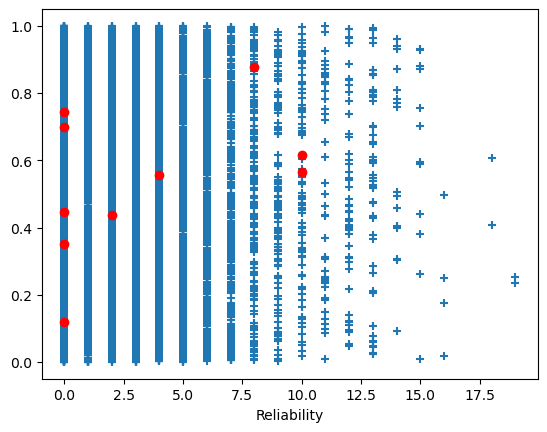

In [2]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

def computeCNSimilarity(Adj):
    """
    Computes CN reliability of a graph with adjacency matrix Adj.
    
    INPUT
    -----
    Adj : Symmetric np.array() with {0, 1} entries;
        Adjacency matrix of the input graph.
        
    OUTPUT
    ------
    reliability : np.array() with float entries;
        Matrix that shows the reliability of each edge in the graph.
    """

    reliability = np.zeros_like(Adj)
    
    for i in range(Adj.shape[0]):
        for j in range(i+1, Adj.shape[0]):
            if Adj[i,j] == 0:
                commonNeighbors = [k for k in range(Adj.shape[0]) if Adj[i, k] == 1 and Adj[j, k] == 1]
                reliability[i,j] = len(commonNeighbors)
                reliability[j,i] = reliability[i,j]
    
    return reliability


# The code below should show you what the reliability of missing links are.

# Read graph
path = '../Data sets/Link Prediction/link_prediction_similarity1.gz'
G = nx.read_edgelist(path)
Adj = nx.adjacency_matrix(G).toarray()
reliability = computeCNSimilarity(Adj)


def test(reliability):

    # Order reliabilities from lowest to highest to find predictions
    print(len(reliability))
    ind = np.argsort(reliability, axis=None) 
    sortedReliability = np.sort(reliability, axis = None)

    # Give the indices of the truely missing links
    trueMissing = np.ravel_multi_index([[2,22,88,0,0,0,10,36,36,0],[16,34,98,3,7,15,47,46,56,59]],Adj.shape)

    # Plot the reliabilities in a graph. Jitter the y-axis to make most points visible
    yvals = np.random.rand(len(ind))
    xvals = sortedReliability
    plt.scatter(xvals,yvals, marker = "+")

    # Mark the truely missing links in red
    plt.scatter(xvals[np.in1d(ind, trueMissing)], yvals[np.in1d(ind, trueMissing)], c = "red" )
    plt.xlabel("Reliability")
    plt.show()

test(reliability)

Blue crosses: These represent all non-existing edges (missing links) in the graph, plotted by their Common Neighbors (CN) reliability scores. Each cross corresponds to a pair of nodes that are NOT currently connected, with the x-position showing how many common neighbors they have.

Red dots: These represent the truly missing edges - edges that should exist according to some ground truth but are currently missing from the graph. These are the specific node pairs listed in trueMissing: (2,16), (22,34), (88,98), etc.

What you're seeing:

- X-axis: CN reliability scores (number of common neighbors for each missing edge)
- Y-axis: Random jitter values (just to spread points vertically so they don't overlap)

The key insight:

- If the CN similarity method works well for link prediction, you should see most red dots clustered toward the RIGHT side of the plot (high reliability scores)
- If red dots are scattered throughout or toward the left, it suggests CN similarity isn't effectively identifying the truly missing links

Interpretation:

- Red dots on the right = CN successfully identified these missing links as likely
- Red dots on the left = CN failed to recognize these as important missing links

The distribution shows how well CN similarity distinguishes true missing edges from random non-existing edges

**Exercise 2.** Think of a network generated through a configuration model where the degree sequence consists of the element $2$ at all even entries, and $100$ at all odd entries. Which reliability will be bigger: $s^{\texttt{CN}}_{13}$ or $s^{\texttt{CN}}_{24}$? Why is this a problem? Create a new similarity score that solves the issues raised by this example, en test it on ```link_prediction_similarity1.gz```. Did the performance improve?

In the configuration model example, $s^{\texttt{CN}}_{13}$ will be much larger than $s^{\texttt{CN}}_{24}$ because nodes 1 and 3 (odd indices) have degree 100, creating many potential common neighbors, while nodes 2 and 4 (even indices) have degree 2, severely limiting common neighbors.
This is problematic because high-degree nodes dominate the similarity scores regardless of actual relationship strength.

/tmp/ipykernel_8461/3039477207.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adj = nx.adjacency_matrix(G).toarray()


100


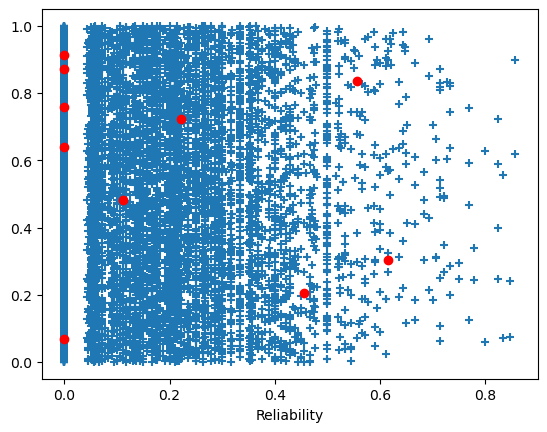

In [3]:
from math import sqrt
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

def computeCNSimilarity_normalized(Adj):
    """
    Computes CN reliability of a graph with adjacency matrix Adj, normalized by the minimum degree of the node pair.
    
    INPUT
    -----
    Adj : Symmetric np.array() with {0, 1} entries;
        Adjacency matrix of the input graph.
        
    OUTPUT
    ------
    reliability : np.array() with float entries;
        Matrix that shows the reliability of each edge in the graph.
    """
    reliability = np.zeros_like(Adj, dtype=float)
    
    for i in range(Adj.shape[0]):
        for j in range(i+1, Adj.shape[0]):
            if Adj[i, j] == 0:
                commonNeighbors = [k for k in range(Adj.shape[0]) if Adj[i, k] == 1 and Adj[j, k] == 1]
                deg_i = Adj[i].sum()
                deg_j = Adj[j].sum()
                denom = min(deg_i, deg_j)
                if denom > 0:
                    reliability[i, j] = len(commonNeighbors) / denom
                    reliability[j, i] = reliability[i, j]
    return reliability

# Read graph
path = '../Data sets/Link Prediction/link_prediction_similarity1.gz'
G = nx.read_edgelist(path)
Adj = nx.adjacency_matrix(G).toarray()
reliability = computeCNSimilarity_normalized(Adj)
test(reliability)

In the previous exercise you have probably seen that performance indeed increased a little with your new metric. At the very least you should have seen some improvement for the missing arcs that already had a (relatively) high reliability in the first exercise. This should show that the usefulness of a similarity metric really depends on the type of network data you are dealing with.

**Exercise 3.** Compare the solution used in the previous exercise to the *Salton*, *Jaccard* and *Sørensen* index in literature. Was your solution the same as one of these indices? *NetworkX* has an out-of-the-box implementation of four local similarity indices (on of them being the Jaccard index). Try them out on ```link_prediction_similarity1.gz```. Which works best? Can you think of a reason for this?

In [4]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

# Your answer goes here

## Similarity based methods - Global

You have now done some link prediction on some local similarity indices, and you have even designed one such index yourself. Of course, you can argue that local indices are not perfect, since they do not incorporate information about the whole graph when predicting links. Global similarity indices do use all available information of the graph. They can often be written as a function of the graph's adjacency matrix. The simplest example is maybe the **Katz index** (KI). This index gives to vertices $v, w \in V$ a higher similarity index if there are more (short) paths connecting the two vertices.

If $A$ is the adjacency matrix of a graph, then note that the matrix power $A^n$ counts all the paths of length $n$ between two vertices. Hence, we can write the Katz index as $$S^{\texttt{Katz}} = \sum_{n = 1}^\infty \beta^n A^n.$$ Here, $\beta$ is a parameter that should be chosen small enough such that the sum converges. The smaller $\beta$ is chosen, the less long paths matter. If the aforementioned sum converges, then it converges to the following value: $$S^{\texttt{Katz}} = (I - \beta A)^{-1} - I.$$ Here, $I$ is the identity matrix. The reliability of vertex-pair $v, w \in V$ is now given by entry $(v, w)$ in the matrix $S^{\texttt{Katz}}$.

**Exercise 4.** Implement the Katz index and try it on ```link_prediction_similarity1.gz```. Use (at least) the following parameter values: $\beta = \{1/20, 1/25, 1/50, 1/1000\}$. For which values of $\beta$ did the algorithm break and why? Also, What do you notice as $\beta \to 0$? Can you explain this? Finally, does the Katz index work better than any of the local indices?

In [5]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

# Your answer goes here

Of course, the Katz index is not the only global similarity index out there. There is a whole zoo of global indices, like the **average commute time index**, the **matrix forest index** or the **Leicht-Holme-Newman index**. Like with the local indices, all have their place to shine and their effectiveness heavily depends on how the dataset is constructed. Often, for global similarity indices it is harder to check whether your dataset meets its underlying assumptions.

**Exercise 5$\star$.** Look up these three global similarity indices in litarature, and choose your favourite. Implement this index and do link prediction on ```link_prediction_similarity1.gz```. Does it work better than the Katz index? 

In [6]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

# Your answer goes hee

You have now probably seen that global similarity scores do not always work better than local ones. There is one final class of similarity based methods that seek to take the best of both worlds: **Quasi-local indices**. These use information from more vertices than the direct neighbors of a target vertex pair, but they do not use information of all vertices in the graph. One with a out-of-the-box implementation in NetworkX, is the **Common Neighbor and Centrality based Parameterized Algorithm** (CCPA) score. It has one free parameter $\alpha \in [0, 1]$, and if $s_{vw}^{\texttt{CCPA}}$ denotes the CCPA score of two vertices $v, w \in V$, then it is given by $$s_{vw}^{\texttt{CCPA}} = \alpha \cdot |\Gamma(v) \cap \Gamma(w)| + (1 - \alpha) \cdot \frac{N}{d_{vw}}.$$ Here, $\Gamma(v)$ denotes the set of neighbours of $v$, $N$ is the total number of nodes and $d_{vw}$ is the distance between $v$ and $w$.

**Exercise 6.** Use the NetworkX implementation of CCPA to do link prediction on ```link_prediction_similarity1.gz```. Try to find which value of $\alpha$ works best. How does this method perform compared to the local and global methods you have seen?

In [7]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

# Your answer goes here

We now reveal that the data in ```link_prediction_similarity1``` was generated through a stochastic block model. The code is given below. You have seen some methods that were biassed, some methods that performed poorly, and some methods that performed relatively okay (ranking the first missing vertex around place 15 out of 10000). However, you have never really seen a method where the missing vertices overwhelmingly come out on top. You also could not really expect this given the way how the data was generated.

In [8]:
import networkx as nx

G = nx.stochastic_block_model([20, 30, 50], [[0.8, 0.1, 0.02], [0.1, 0.6, 0.1], [0.02, 0.1, 0.3]], seed = 1)
G.edges
G.remove_edge(2, 16)
G.remove_edge(22, 34)
G.remove_edge(88, 98)
G.remove_edge(0, 3)
G.remove_edge(0, 7)
G.remove_edge(0, 15)
G.remove_edge(10, 47)
G.remove_edge(36, 46)
G.remove_edge(36, 56)
G.remove_edge(0, 59)
nx.write_edgelist(G, "link_prediction_similarity1.gz")

**Exercise 7.** Explain why it would be almost impossible for a link prediction method to retrieve all missing links.

## Real data and validation

We will end the workshop by looking at a real dataset. This is a dataset where nodes are dolphins and each link between two nodes represents "frequent association". The dataset is given in ```link_prediction_similarity2.gz```. We have removed three edges ($\{29, 48\}, \{58, 49\}, \{9, 60\}$).

**Exercise 8.** Use your favourite link prediction method on the Dolphin dataset. What would be a good choice of similarity score and why? *Hint: link $\{58, 49\}$ is most difficult to predict.*

In [18]:
# We will end the workshop by looking at a real dataset. This is a dataset where nodes are dolphins and each link between two nodes represents "frequent association". The dataset is given in ```link_prediction_similarity2.gz```. We have removed three edges ($\{29, 48\}, \{58, 49\}, \{9, 60\}$).
#**Exercise 8.** Use your favourite link prediction method on the Dolphin dataset. What would be a good choice of similarity score and why? *Hint: link $\{58, 49\}$ is most difficult to predict.*
def computeJaccardSimilarity(Adj):
    """
    Computes Jaccard reliability of a graph with adjacency matrix Adj.
    
    INPUT
    -----
    Adj : Symmetric np.array() with {0, 1} entries;
        Adjacency matrix of the input graph.
        
    OUTPUT
    ------
    reliability : np.array() with float entries;
        Matrix that shows the reliability of each edge in the graph.
    """

    reliability = np.zeros_like(Adj, dtype=float)
    
    for i in range(Adj.shape[0]):
        for j in range(i+1, Adj.shape[0]):
            if Adj[i,j] == 0:
                neighbors_i = set(np.where(Adj[i] == 1)[0])
                neighbors_j = set(np.where(Adj[j] == 1)[0])
                intersection = neighbors_i.intersection(neighbors_j)
                union = neighbors_i.union(neighbors_j)
                if len(union) > 0:
                    reliability[i,j] = len(intersection) / len(union)
                    reliability[j,i] = reliability[i,j]
    
    return reliability

#print the reliability of the missing links
# Read graph
path = '../Data sets/Link Prediction/link_prediction_similarity2.gz'
G = nx.read_edgelist(path)
Adj = nx.adjacency_matrix(G).toarray()
reliability = computeJaccardSimilarity(Adj)
print(reliability[29, 48], reliability[58, 49], reliability[9, 60])

0.0 0.0 0.0


/tmp/ipykernel_8461/4267899404.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adj = nx.adjacency_matrix(G).toarray()


In certain exercises you were asked to assess the performance of a link prediction algorithm. You have probably found out that this is not an easy task. In general, validation for link prediction is a difficult talk, since we do not know that the actual network looks like. Usually this lack of a ground truth is mediated by using **cross-validation** methods. The idea is to remove extra edges from a network, and using the link prediction method to assess how well these extra edges are retrieved. By doing this multiple times, and averaging over the results you can obtain a score that tells you how well the link prediction method performs on a given problem.

**Exercise 9.** The code below implements a specific cross-validation method for the Jaccard index. Find out what the code does, and add comments to explain the procedure. Then, adapt it to other link prediction methods and test it on the Dolphin dataset to validate different link prediction methods.

In [16]:
def leaveOneOutJaccard(G):
    AUC = 0
    for e in G.edges:
        Gprobed = G.copy()
        Gprobed.remove_edge(e[0],e[1])
        target = nx.jaccard_coefficient(Gprobed, [e])
        for _, _, p in target:
            reliabilityTarget = p
        
        reliability = nx.jaccard_coefficient(Gprobed)
        better = 0
        same = 0
        total = 0
        for _, _, p in reliability:
            if p < reliabilityTarget:
                better += 1
            elif p == reliabilityTarget:
                same += 1
            total += 1
        
        AUC += (0.5 * same + better) / total
    return AUC / len(G.edges)

#we apply it to the dolphin dataset
path = '../Data sets/Link Prediction/link_prediction_similarity2.gz'
G = nx.read_edgelist(path)
print(leaveOneOutJaccard(G))

0.7794814389590506


In this workshop you have now tried out some similarity based link prediction methods on both real and synthetic data. You should now have noticed the following:
- Link prediction is a difficult task, and in practice it is almost impossible to retrieve the missing links exactly.
- The performance of similarity based link prediction methods depends heavily on the chosen similarity metric.
- Similarity based methods are often fast and easy to implement. Local metrics more so than global ones.
- Using more complex similarity based method is not always better.
- It is not easy to validate and assess performance of link prediction algorithms (more on this in a later lecture).